In [1]:
import sys
import os

sys.path.append(os.path.abspath(".."))

from src.data.loader import load_prices, compute_returns
from outputs.charts.markowitz_plot import plot_efficient_frontier
from src.models.lr import predict_mean_returns
from src.optimization.markowitz import minimize_volatility

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

from src.models.lr import evaluate_linear_model, inspect_coefficients

from src.optimization.evaluation import evaluate_portfolio



In [2]:
tickers = ["PETR4.SA", "VALE3.SA", "ITUB4.SA", "BBDC4.SA", "BBAS3.SA", "ABEV3.SA", "WEGE3.SA", "B3SA3.SA", "GGBR4.SA"] # "MGLU3.SA"
start_date = "2017-01-01"
end_date = "2023-01-01"

# Frequência desejada: 'daily', 'weekly', 'monthly', 'annual'
#frequencia_retorno = 'monthly'
#target_return = 0.01
risk_free_rate = 0.15

In [3]:

prices = load_prices(tickers, start=start_date, end=end_date)

returns_daily = compute_returns(prices, freq='daily')
returns_monthly = compute_returns(prices, freq='monthly')
returns_annually = compute_returns(prices, freq='annually')

mean_returns_daily = returns_daily.mean()
cov_matrix_daily = returns_daily.cov()

mean_returns_monthly = returns_monthly.mean()
cov_matrix_monthly = returns_monthly.cov()

mean_returns_annually = returns_annually.mean()
cov_matrix_annually = returns_annually.cov()

/workspaces/deep_learning_finance/src/data/loader.py:9: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(tickers, start=start, end=end)['Close']
[*********************100%***********************]  9 of 9 completed


In [4]:
prices.shape

(1493, 9)

(9,) (1493, 9)
Retornos esperados (Regressão Linear):
ABEV3.SA    0.002896
B3SA3.SA    0.012725
BBAS3.SA    0.002623
BBDC4.SA    0.001072
GGBR4.SA    0.000837
ITUB4.SA    0.000764
PETR4.SA    0.012652
VALE3.SA    0.014082
WEGE3.SA   -0.009489
Name: Predicted_Mean_Returns, dtype: float64


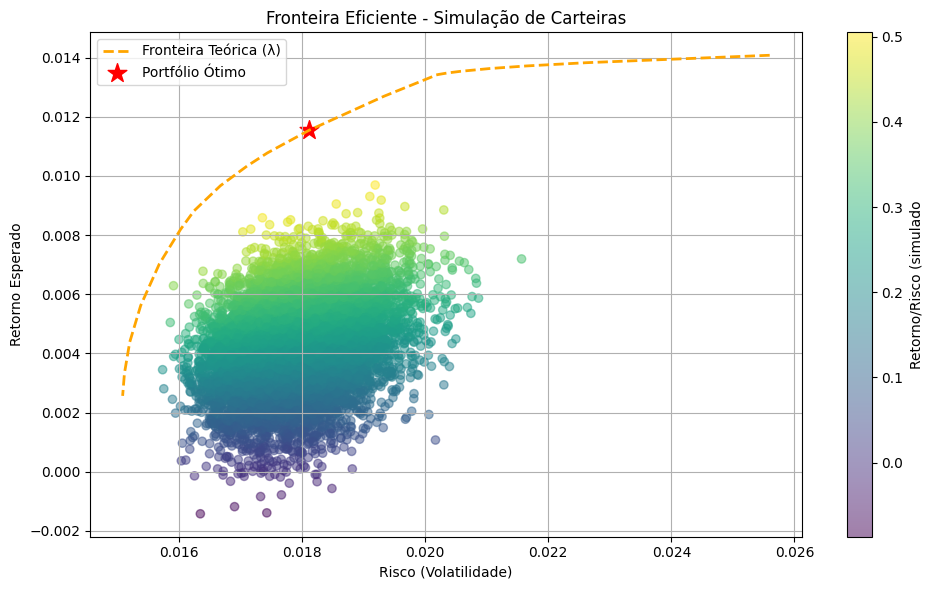

In [5]:


# Prever retornos esperados via regressão linear
from src.optimization.markowitz import solve_markowitz


predicted_means = predict_mean_returns(prices, window=5)
print(predicted_means.shape, prices.shape)

print("Retornos esperados (Regressão Linear):")
print(predicted_means)

# Substituir as médias históricas
mean_returns_pred = predicted_means

# Continuar normalmente com Markowitz

#weights_pred = minimize_volatility(mean_returns_pred, cov_matrix_daily)
weights_pred = solve_markowitz(mean_returns_pred, cov_matrix_daily, 0.5)

plot_efficient_frontier(mean_returns_pred, cov_matrix_daily, optimized_weights=weights_pred)
#mas por que eu estou usando esse returns_daily como parametro se o modelo propor a criar um retorno medio, sendo o predicted_means = predict_mean_returns(prices, window=5)? mean_returns_pred = predicted_means


In [6]:
predicted_means

ABEV3.SA    0.002896
B3SA3.SA    0.012725
BBAS3.SA    0.002623
BBDC4.SA    0.001072
GGBR4.SA    0.000837
ITUB4.SA    0.000764
PETR4.SA    0.012652
VALE3.SA    0.014082
WEGE3.SA   -0.009489
Name: Predicted_Mean_Returns, dtype: float64

In [7]:
eval_results = evaluate_linear_model(prices, window=5)
print(eval_results)

     Ticker       MSE        R²  Correlação
0  ABEV3.SA  0.000204  0.197650    0.460275
1  B3SA3.SA  0.000553  0.253124    0.519130
2  BBAS3.SA  0.000381  0.090868    0.387977
3  BBDC4.SA  0.000364  0.151892    0.436263
4  GGBR4.SA  0.000518  0.142366    0.408663
5  ITUB4.SA  0.000247  0.139899    0.425274
6  PETR4.SA  0.000505  0.246003    0.522620
7  VALE3.SA  0.000484  0.208915    0.476626
8  WEGE3.SA  0.000368  0.276888    0.526713


In [8]:
coefs = inspect_coefficients(prices, window=5)
print(coefs.head(10))

                 ABEV3.SA  B3SA3.SA  BBAS3.SA  BBDC4.SA  GGBR4.SA  ITUB4.SA  \
ABEV3.SA_lag1   -0.005652 -0.001866 -0.002278 -0.002419 -0.003005 -0.000764   
ABEV3.SA_mean_5  0.009957 -0.000925  0.000157 -0.000196  0.000391 -0.001071   
ABEV3.SA_std_5   0.000526  0.000082 -0.000601 -0.000738  0.000094 -0.000402   
B3SA3.SA_lag1   -0.000069 -0.007415 -0.001038 -0.001012 -0.000717 -0.001312   
B3SA3.SA_mean_5  0.001001  0.014290  0.000865  0.000173  0.002387  0.001010   
B3SA3.SA_std_5   0.000370 -0.000082  0.001348  0.001545 -0.000694  0.000960   
BBAS3.SA_lag1   -0.001279  0.000723 -0.005966 -0.000280  0.000654  0.000550   
BBAS3.SA_mean_5 -0.000491 -0.002297  0.012455 -0.000880 -0.000538 -0.001181   
BBAS3.SA_std_5   0.000963 -0.000524  0.001060 -0.000340  0.000750  0.000711   
BBDC4.SA_lag1    0.000060  0.001350  0.002175 -0.005010  0.001198  0.000526   

                 PETR4.SA  VALE3.SA  WEGE3.SA  
ABEV3.SA_lag1   -0.003643 -0.003311 -0.000321  
ABEV3.SA_mean_5  0.000525  0.00123

In [9]:

results_linear = evaluate_portfolio(
    returns=returns_daily,
    weights=weights_pred,
    freq='daily',
    model_name='linear_metrics',
)

pd.DataFrame([results_linear]).to_csv("../outputs/models/linear_metrics.csv", index=False)


In [10]:
df_pesos = pd.DataFrame({
    "Ticker": tickers,
    "Peso Markowitz LR": weights_pred,
})
print(df_pesos.sort_values("Peso Markowitz LR", ascending=False).round(4))

     Ticker  Peso Markowitz LR
7  B3SA3.SA             0.4272
1  VALE3.SA             0.3307
0  PETR4.SA             0.1790
6  WEGE3.SA             0.0632
3  BBDC4.SA             0.0000
2  ITUB4.SA             0.0000
4  BBAS3.SA             0.0000
5  ABEV3.SA             0.0000
8  GGBR4.SA             0.0000
